# R6 - Adversarial Robustness Evaluation and Training

In this notebook, we'll evaluate the adversarial robustness of our three trained models (Center Loss, Siamese Network, and Triplet Loss) and implement adversarial training to improve their robustness against various attacks.

## Project Overview

Building on our previous implementations, we'll:

1. Load and initialize all three trained models
2. Implement various adversarial attacks using torchattacks
3. Evaluate robustness across different attack methods and strengths on similarity assessment tasks
4. Implement adversarial training for each model type
5. Compare clean vs. adversarially robust models

The goal is to understand how vulnerable our similarity models are to adversarial examples and develop more robust versions.


## Section 1: Environment Setup

First, let's install the necessary packages and import the required libraries.

In [4]:
# Install necessary packages
!pip install torch torchvision timm matplotlib seaborn scikit-learn pandas torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# Import necessary libraries
import os
import glob
import time
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Import timm for model backbones
import timm

# Import torchattacks for adversarial attacks
import torchattacks

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Enable inline plotting
%matplotlib inline

In [6]:
# Set global seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

# Set global configuration
CONFIG = {
    'output_dir': 'output',
    'model_dir': 'models',
    'robust_model_dir': 'robust_models',

    # Model parameters
    'image_size': 224,
    'embedding_dim': 512,
    'num_classes': 102,

    # Adversarial training parameters
    'adv_epochs': 10,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,

    # Adversarial attack parameters
    'epsilon_values': [0.0, 0.05, 0.1], # [0.0, 0.01, 0.02, 0.03, 0.05, 0.1],
    'pgd_steps': 10,
    'pgd_alpha': 0.01,

    # Other settings
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

print(f"Using device: {CONFIG['device']}")

# Create output directories if they don't exist
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)
os.makedirs(CONFIG['robust_model_dir'], exist_ok=True)

Using device: cuda


## Section 2: Dataset Loading and Preparation

Now, let's load the data and create appropriate datasets for each model type.

In [7]:
# Check if dataset files exist, download if necessary
if not os.path.exists('imagelabels.mat') or not os.path.exists('setid.mat'):
    print("Downloading dataset files...")

    if not os.path.exists('102flowers.tgz'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

    if not os.path.exists('imagelabels.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

    if not os.path.exists('setid.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

    if not os.path.exists('jpg'):
        !tar -xzf 102flowers.tgz

    print("Download and extraction complete.")
else:
    print("Dataset files already exist.")

# Helper function to load MAT files with fallback
def load_mat(filepath):
    """Load MAT file with fallback to h5py for newer MAT file formats."""
    try:
        from scipy.io import loadmat
        return loadmat(filepath)
    except:
        import h5py
        with h5py.File(filepath, 'r') as f:
            data = {key: value[:] for key, value in f.items()}
        return data

# Load image labels and dataset split information
image_labels = load_mat("imagelabels.mat")
setid = load_mat("setid.mat")

# Extract labels and dataset splits
labels = image_labels["labels"]
train_ids = setid["tstid"].flatten() if "tstid" in setid else setid["tst"].flatten()
validation_ids = setid["valid"].flatten()
test_ids = setid["trnid"].flatten() if "trnid" in setid else setid["trn"].flatten()

print(f"Dataset contains {labels.shape[1]} images with {len(np.unique(labels))} classes")
print(f"Train set: {len(train_ids)} images")
print(f"Validation set: {len(validation_ids)} images")
print(f"Test set: {len(test_ids)} images")

--2025-07-22 22:36:35--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-07-22 22:36:35--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  28.4MB/s    in 13s     

2025-07-22 22:36:49 (25.7 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2025-07-22 22:36:49--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels

In [8]:
# Get list of all image files and associate them with labels
image_dir = Path("jpg")
image_paths = sorted(list(image_dir.glob('image_*.jpg')),
                    key=lambda x: int(x.stem.split('_')[1]))

print(f"Found {len(image_paths)} image files")

# Create a mapping from image paths to labels and dataset splits
image_info = []

for img_path in image_paths:
    img_id = int(img_path.stem.split('_')[1])

    if img_id <= len(labels[0]):
        label = labels[0, img_id-1]

        if img_id in train_ids:
            dataset_split = 'train'
        elif img_id in validation_ids:
            dataset_split = 'validation'
        elif img_id in test_ids:
            dataset_split = 'test'
        else:
            dataset_split = 'unknown'

        image_info.append({
            'image_id': img_id,
            'path': str(img_path),
            'label': int(label),
            'split': dataset_split
        })

# Convert to DataFrame for easier processing
image_df = pd.DataFrame(image_info)

print("\nImage distribution by split:")
print(image_df['split'].value_counts())

Found 8189 image files

Image distribution by split:
split
train         6149
validation    1020
test          1020
Name: count, dtype: int64


In [9]:
# Dataset classes for different model types

class FlowerClassificationDataset(Dataset):
    """Dataset for Center Loss model (classification)."""
    def __init__(self, df, split='train', transform=None):
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label'] - 1  # Convert to 0-based indexing

        if self.transform:
            image = self.transform(image)

        return image, label

import random
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class FlowerPairDataset(Dataset):
    """
    Dataset for Siamese Network supporting:
    - Fixed # of positive pairs per class (like FlowerPairDataset)
    - One pair per image (original logic)
    """
    def __init__(self, df, split='validation', transform=None,
                 pairs_per_class=10, total_neg_pairs=None,
                 fixed_pairs_per_class=True, seed=None):
        """
        Args:
            df: DataFrame with 'path', 'label', and 'split'.
            split: Dataset split ('train', 'validation', 'test').
            transform: Optional transform.
            pairs_per_class: Number of positive pairs per class if fixed.
            total_neg_pairs: Number of negative pairs to generate.
            fixed_pairs_per_class: If False, generate one pair per image (50/50 pos/neg).
            seed: Random seed for reproducibility.
        """
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.class_indices = {}
        for idx, row in self.df.iterrows():
            self.class_indices.setdefault(row['label'], []).append(idx)

        self.pairs, self.pair_labels = self._generate_pairs(
            pairs_per_class, total_neg_pairs, fixed_pairs_per_class
        )

    def _generate_pairs(self, pairs_per_class, total_neg_pairs, fixed_pairs_per_class):
        pairs = []
        pair_labels = []

        if fixed_pairs_per_class:
            for label, indices in self.class_indices.items():
                if len(indices) < 2:
                    continue
                seen = set()
                attempts = 0
                max_attempts = pairs_per_class * 10
                while len(seen) < pairs_per_class and attempts < max_attempts:
                    idx1, idx2 = random.sample(indices, 2)
                    key = tuple(sorted((idx1, idx2)))
                    if key not in seen:
                        seen.add(key)
                        pairs.append(key)
                        pair_labels.append(1)
                    attempts += 1

            # Generate negative pairs
            if total_neg_pairs is None:
                total_neg_pairs = len(pair_labels)

            labels = list(self.class_indices.keys())
            seen = set()
            while len(pair_labels) - sum(pair_labels) < total_neg_pairs:
                label1, label2 = random.sample(labels, 2)
                idx1 = random.choice(self.class_indices[label1])
                idx2 = random.choice(self.class_indices[label2])
                key = (idx1, idx2)
                if key not in seen:
                    seen.add(key)
                    pairs.append(key)
                    pair_labels.append(0)
        else:
            for idx1 in range(len(self.df)):
                label1 = self.df.loc[idx1, 'label']
                is_positive = np.random.rand() < 0.5

                if is_positive and len(self.class_indices[label1]) > 1:
                    idx2_candidates = [i for i in self.class_indices[label1] if i != idx1]
                    idx2 = random.choice(idx2_candidates)
                    label = 1
                else:
                    other_labels = list(set(self.class_indices.keys()) - {label1})
                    label2 = random.choice(other_labels)
                    idx2 = random.choice(self.class_indices[label2])
                    label = 0

                pairs.append((idx1, idx2))
                pair_labels.append(label)

        return pairs, pair_labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        idx1, idx2 = self.pairs[idx]

        img1 = Image.open(self.df.loc[idx1, 'path']).convert('RGB')
        img2 = Image.open(self.df.loc[idx2, 'path']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.FloatTensor([self.pair_labels[idx]])
        return (img1, img2), label

class FlowerTripletDataset(Dataset):
    """Dataset for Triplet Network (triplets)."""
    def __init__(self, df, split='train', transform=None, shuffle_triplets=True):
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform
        self.shuffle_triplets = shuffle_triplets

        self.class_indices = {}
        for idx, row in self.df.iterrows():
            label = row['label']
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)

        self.valid_classes = [cls for cls, indices in self.class_indices.items() if len(indices) >= 2]
        self.triplets = self.generate_triplets()

    def generate_triplets(self):
        triplets = []

        for anchor_class in self.valid_classes:
            anchor_indices = self.class_indices[anchor_class]

            for i, anchor_idx in enumerate(anchor_indices):
                pos_indices = anchor_indices.copy()
                pos_indices.remove(anchor_idx)
                pos_idx = random.choice(pos_indices)

                neg_classes = [c for c in self.valid_classes if c != anchor_class]
                neg_class = random.choice(neg_classes)
                neg_idx = random.choice(self.class_indices[neg_class])

                triplets.append((anchor_idx, pos_idx, neg_idx))

        if self.shuffle_triplets:
            random.shuffle(triplets)

        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, pos_idx, neg_idx = self.triplets[idx]

        anchor_img = Image.open(self.df.loc[anchor_idx, 'path']).convert('RGB')
        pos_img = Image.open(self.df.loc[pos_idx, 'path']).convert('RGB')
        neg_img = Image.open(self.df.loc[neg_idx, 'path']).convert('RGB')

        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return (anchor_img, pos_img, neg_img), (self.df.loc[anchor_idx, 'label'],
                                                self.df.loc[pos_idx, 'label'],
                                                self.df.loc[neg_idx, 'label'])

In [10]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'] + 32, CONFIG['image_size'] + 32)),
    transforms.RandomCrop(CONFIG['image_size']),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets for each model type - all using pair datasets for similarity assessment
# Center Loss datasets (using pairs for adversarial evaluation)
center_train_dataset = FlowerClassificationDataset(image_df, split='train', transform=train_transform)
center_val_dataset = FlowerPairDataset(image_df, split='validation', transform=transform, seed=42)
center_val_classification_dataset = FlowerClassificationDataset(image_df, split='validation', transform=transform)
center_test_dataset = FlowerPairDataset(image_df, split='test', transform=transform, seed=42)

# Siamese datasets
siamese_train_dataset = FlowerPairDataset(image_df, split='train', transform=train_transform, seed=42, fixed_pairs_per_class=False)
siamese_val_dataset = FlowerPairDataset(image_df, split='validation', transform=transform, seed=42)
siamese_test_dataset = FlowerPairDataset(image_df, split='test', transform=transform, seed=42)

# Triplet datasets (using pairs for adversarial evaluation)
triplet_train_dataset = FlowerTripletDataset(image_df, split='train', transform=train_transform)
triplet_val_dataset = FlowerPairDataset(image_df, split='validation', transform=transform, seed=42)
triplet_test_dataset = FlowerPairDataset(image_df, split='test', transform=transform, seed=42)

# Create data loaders
center_test_loader = DataLoader(center_test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

print(f"Created datasets:")
print(f"Center Loss - Train: {len(center_train_dataset)}, Val: {len(center_val_dataset)}, Test: {len(center_test_dataset)}")
print(f"Siamese - Train: {len(siamese_train_dataset)}, Val: {len(siamese_val_dataset)}, Test: {len(siamese_test_dataset)}")
print(f"Triplet - Train: {len(triplet_train_dataset)}, Val: {len(triplet_val_dataset)}, Test: {len(triplet_test_dataset)}")

Created datasets:
Center Loss - Train: 6149, Val: 2040, Test: 2040
Siamese - Train: 6149, Val: 2040, Test: 2040
Triplet - Train: 6149, Val: 2040, Test: 2040


## Section 3: Model Architecture Definitions

Let's recreate the model architectures from our previous notebooks.

In [11]:
class CenterLoss(nn.Module):
    """
    Center loss.

    Reference:
        Wen et al. "A Discriminative Feature Learning Approach for Deep Face Recognition." ECCV 2016.

    Args:
        num_classes (int): Number of classes.
        feat_dim (int): Feature dimension (embedding size).
        use_gpu (bool): Whether to use GPU for center storage.

    Forward Args:
        x (Tensor): Feature matrix of shape (batch_size, feat_dim).
        labels (Tensor): Ground truth labels of shape (batch_size,).

    Returns:
        loss (Tensor): Scalar center loss value, which encourages features of the same class to be close to their class center.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        # Initialize centers for each class as learnable parameters
        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Compute the center loss.

        Args:
            x (Tensor): Feature matrix with shape (batch_size, feat_dim).
            labels (Tensor): Ground truth labels with shape (batch_size,).

        Returns:
            loss (Tensor): Scalar center loss value.
        """
        batch_size = x.size(0)

        # Compute squared Euclidean distance between each feature and each class center
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(x, self.centers.t(), beta=1, alpha=-2)

        # Create a mask for the ground truth class of each sample
        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        # Only keep distances to the correct class center for each sample
        dist = distmat * mask.float()

        # Compute the mean loss over the batch
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

class CenterLossNetwork(nn.Module):
    """Center Loss Network for flower classification"""
    def __init__(self, backbone_name='resnet18', pretrained=True, num_classes=102,
                 embedding_dim=512, training_mode='transfer_learning'):
        super(CenterLossNetwork, self).__init__()

        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0)

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            backbone_output_dim = self.backbone(dummy_input).shape[1]

        self.embedding = nn.Sequential(
            nn.Linear(backbone_output_dim, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.training_mode = training_mode
        self._apply_training_mode()

    def _apply_training_mode(self):
        if self.training_mode == 'transfer_learning':
            for param in self.backbone.parameters():
                param.requires_grad = False
        elif self.training_mode == 'fine_tuning':
            # Freeze early layers
            layers_to_freeze = []
            if hasattr(self.backbone, 'layer1'):
                layers_to_freeze.extend(['conv1', 'bn1', 'act1', 'maxpool', 'layer1', 'layer2'])

            for name, param in self.backbone.named_parameters():
                param.requires_grad = True
                for layer_name in layers_to_freeze:
                    if layer_name in name:
                        param.requires_grad = False
                        break

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.embedding(features)
        logits = self.classifier(embeddings)
        return logits, embeddings

    def get_embedding(self, x):
        features = self.backbone(x)
        embeddings = self.embedding(features)
        return F.normalize(embeddings, p=2, dim=1)

    def compute_similarity(self, img1, img2):
        embed1 = self.get_embedding(img1)
        embed2 = self.get_embedding(img2)
        similarity = torch.sum(embed1 * embed2, dim=1)
        return torch.sigmoid(similarity * 5)

In [12]:
class SiameseNetwork(nn.Module):
    """
    Siamese Network architecture for image similarity tasks.
    Uses a shared backbone network to extract features from both images,
    then computes similarity between the extracted features.
    """
    def __init__(self, backbone_name='resnet18', pretrained=True, embedding_dim=None, training_mode='transfer_learning'):
        """
        Initialize the Siamese network.

        Args:
            backbone_name: Name of the backbone network from timm
            pretrained: Whether to use pretrained weights
            embedding_dim: Dimension of the embedding layer (None to skip embedding)
            training_mode: One of 'full_training', 'fine_tuning', 'transfer_learning'
        """
        super(SiameseNetwork, self).__init__()

        # Create backbone network from timm
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Apply training mode settings
        self.training_mode = training_mode
        self._apply_training_mode()

        # Get the output dimension of the backbone
        # For testing the output dimension, pass a dummy input through the backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, CONFIG['image_size'], CONFIG['image_size'])
            backbone_output_dim = self.backbone(dummy_input).shape[1]

        print(f"Backbone: {backbone_name}, Output dimension: {backbone_output_dim}")
        print(f"Training mode: {training_mode}")

        # Optional embedding layer
        self.embedding_dim = embedding_dim
        if embedding_dim is not None:
            self.embedding = nn.Sequential(
                nn.Linear(backbone_output_dim, embedding_dim),
                nn.BatchNorm1d(embedding_dim),
                nn.ReLU(inplace=True)
            )
            final_dim = embedding_dim
        else:
            self.embedding = nn.Identity()
            final_dim = backbone_output_dim

        # Similarity head
        self.similarity_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(final_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        """Forward pass for a single image"""
        features = self.backbone(x)
        embedding = self.embedding(features)
        return embedding

    def _apply_training_mode(self):
        """Apply the selected training mode to the network"""
        if self.training_mode == 'transfer_learning':
            # Freeze the entire backbone
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Transfer learning mode: backbone frozen, only training embedding and similarity head")

        elif self.training_mode == 'fine_tuning':
            # Freeze early layers, train later layers
            # This is a common approach for fine-tuning
            layers_to_freeze = []

            # Handle different model architectures
            if hasattr(self.backbone, 'stem'):
                # Vision transformer style models often have a stem
                layers_to_freeze.append('stem')

            if hasattr(self.backbone, 'stages') and len(self.backbone.stages) > 2:
                # For models with stages (like RegNet, ConvNext, etc.)
                # Freeze early stages, keep later ones trainable
                early_stages = len(self.backbone.stages) // 2
                for i in range(early_stages):
                    layers_to_freeze.append(f'stages.{i}')

            elif hasattr(self.backbone, 'layer1'):
                # ResNet style models
                layers_to_freeze.extend(['conv1', 'bn1', 'act1', 'maxpool', 'layer1', 'layer2'])

            elif hasattr(self.backbone, 'blocks') and len(self.backbone.blocks) > 4:
                # Vision transformer style with blocks
                block_count = len(self.backbone.blocks)
                blocks_to_freeze = block_count // 2
                for i in range(blocks_to_freeze):
                    layers_to_freeze.append(f'blocks.{i}')

            # Apply freezing
            for name, param in self.backbone.named_parameters():
                param.requires_grad = True  # Default to trainable
                for layer_name in layers_to_freeze:
                    if layer_name in name:
                        param.requires_grad = False
                        break

            print(f"Fine-tuning mode: {len(layers_to_freeze)} early layers/blocks frozen, later layers trainable")

        else:  # full_training
            # Train the entire network
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("Full training mode: all layers trainable")

    def forward(self, img1, img2):
        """
        Forward pass for a pair of images.

        Args:
            img1: First image tensor [B, C, H, W]
            img2: Second image tensor [B, C, H, W]

        Returns:
            similarity: Similarity score between the images [B, 1]
        """
        # Extract features from both images
        feat1 = self.forward_one(img1)
        feat2 = self.forward_one(img2)

        # Compute element-wise product of features
        combined_features = feat1 * feat2

        # Pass through similarity head
        similarity = self.similarity_head(combined_features)

        return similarity

    def get_embedding(self, x):
        """Get embeddings for a batch of images (for visualization)"""
        return self.forward_one(x)


In [13]:
# Triplet Network
class TripletNetwork(nn.Module):
    """Triplet Network for image similarity using triplet loss"""
    def __init__(self, backbone_name='resnet18', pretrained=True, embedding_dim=128, training_mode='transfer_learning'):
        super(TripletNetwork, self).__init__()

        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0)

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            backbone_output_dim = self.backbone(dummy_input).shape[1]

        self.embedding = nn.Sequential(
            nn.Linear(backbone_output_dim, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(inplace=True)
        )

        self.training_mode = training_mode
        self._apply_training_mode()

    def _apply_training_mode(self):
        if self.training_mode == 'transfer_learning':
            for param in self.backbone.parameters():
                param.requires_grad = False
        elif self.training_mode == 'fine_tuning':
            layers_to_freeze = []
            if hasattr(self.backbone, 'layer1'):
                layers_to_freeze.extend(['conv1', 'bn1', 'act1', 'maxpool', 'layer1', 'layer2'])

            for name, param in self.backbone.named_parameters():
                param.requires_grad = True
                for layer_name in layers_to_freeze:
                    if layer_name in name:
                        param.requires_grad = False
                        break

    def forward_one(self, x):
        features = self.backbone(x)
        embeddings = self.embedding(features)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
        return anchor_embedding, positive_embedding, negative_embedding

    def get_embedding(self, x):
        return self.forward_one(x)

    def compute_similarity(self, img1, img2):
        embed1 = self.forward_one(img1)
        embed2 = self.forward_one(img2)
        similarity = torch.sum(embed1 * embed2, dim=1)
        similarity = torch.sigmoid(similarity * 5)
        return similarity

## Section 4: Model Loading and Initialization

Now let's load our pretrained models from the previous notebooks.

In [39]:
!gdown 1BKrro7PKl8M_OL4lHXibMuI7GgOzhxYe
!gdown 1WXgSpuGzVnS8Jt0bvCM9x7tn0JERVfDM
!gdown 1wx_CfOF6U3RhphJHTq2RaVitppvxo-b0

Downloading...
From (original): https://drive.google.com/uc?id=1BKrro7PKl8M_OL4lHXibMuI7GgOzhxYe
From (redirected): https://drive.google.com/uc?id=1BKrro7PKl8M_OL4lHXibMuI7GgOzhxYe&confirm=t&uuid=e83c7da9-621d-4277-8c89-1caebb0877f6
To: /kaggle/working/best_model_center_loss.pth
100%|███████████████████████████████████████| 60.0M/60.0M [00:00<00:00, 198MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WXgSpuGzVnS8Jt0bvCM9x7tn0JERVfDM
From (redirected): https://drive.google.com/uc?id=1WXgSpuGzVnS8Jt0bvCM9x7tn0JERVfDM&confirm=t&uuid=97bb7630-a1bb-4833-b7b8-e26144b2d1a8
To: /kaggle/working/best_model_siamese_network.pth
100%|██████████████████████████████████████| 60.9M/60.9M [00:00<00:00, 70.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wx_CfOF6U3RhphJHTq2RaVitppvxo-b0
From (redirected): https://drive.google.com/uc?id=1wx_CfOF6U3RhphJHTq2RaVitppvxo-b0&confirm=t&uuid=29860efe-511a-4bab-ab45-a62512fbbd4f
To: /kaggle/working/best_model_triplet_lo

In [40]:
# Load pretrained models
def load_model(model_class, checkpoint_path, **model_kwargs):
    """Load a pretrained model from checkpoint."""
    model = model_class(**model_kwargs)

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=CONFIG['device'], weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {checkpoint_path} (epoch {checkpoint.get('epoch', 'unknown')})")
    else:
        print(f"Checkpoint not found at {checkpoint_path}, using randomly initialized model")

    model = model.to(CONFIG['device'])
    model.eval()
    return model, checkpoint

# Initialize models with appropriate configurations
center_loss_model, center_loss_config = load_model(
    CenterLossNetwork,
    'best_model_center_loss.pth',
    backbone_name='tiny_vit_5m_224.in1k',
    pretrained=True,
    num_classes=CONFIG['num_classes'],
    embedding_dim=CONFIG['embedding_dim'],
    training_mode='fine_tuning'
)

siamese_model, siamese_config = load_model(
    SiameseNetwork,
    'best_model_siamese_network.pth',
    backbone_name='tiny_vit_5m_224.in1k',
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode='fine_tuning'
)

triplet_model, triplet_config = load_model(
    TripletNetwork,
    'best_model_triplet_loss.pth',
    backbone_name='tiny_vit_5m_224.in1k',
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode='fine_tuning'
)

print("All models loaded successfully!")

Loaded model from best_model_center_loss.pth (epoch 8)
Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: fine_tuning
Loaded model from best_model_siamese_network.pth (epoch 20)
Loaded model from best_model_triplet_loss.pth (epoch 11)
All models loaded successfully!


## Section 5: Adversarial Attack Implementation

Now let's implement various adversarial attacks using the torchattacks library.

In [41]:
# Adversarial attack implementations
class AdversarialAttacks:
    """Wrapper class for various adversarial attacks."""

    @staticmethod
    def create_attack(attack_type, model, epsilon=0.03, **kwargs):
        """Create an adversarial attack instance."""
        model.eval()

        if attack_type == 'FGSM':
            return torchattacks.FGSM(model, eps=epsilon)
        elif attack_type == 'PGD':
            return torchattacks.PGD(model, eps=epsilon, alpha=kwargs.get('alpha', epsilon/4),
                                   steps=kwargs.get('steps', 20), random_start=True)
        elif attack_type == 'CW':
            return torchattacks.CW(model, c=kwargs.get('c', 1), kappa=0, steps=kwargs.get('steps', 50))
        elif attack_type == 'DeepFool':
            return torchattacks.DeepFool(model, steps=kwargs.get('steps', 50), overshoot=0.02)
        else:
            raise ValueError(f"Unknown attack type: {attack_type}")

# Model wrappers for different attack targets
class CenterLossWrapper(nn.Module):
    """Wrapper for Center Loss model to work with torchattacks (classification)."""
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        logits, _ = self.model(x)
        return logits

class CenterLossSimilarityWrapper(nn.Module):
    """Wrapper for Center Loss model for similarity-based adversarial attacks."""
    def __init__(self, model, target_images):
        super().__init__()
        self.model = model
        self.target_images = target_images.to(next(model.parameters()).device)

    def forward(self, x):
        # Compute similarity between input and target images
        similarity = self.model.compute_similarity(x, self.target_images)
        # Convert similarity to logits for binary classification (dissimilar=0, similar=1)
        logits = torch.stack([1 - similarity, similarity], dim=1)
        return logits

class SiameseWrapper(nn.Module):
    """Wrapper for Siamese model for similarity-based adversarial attacks."""
    def __init__(self, model, target_images):
        super().__init__()
        self.model = model
        self.target_images = target_images.to(next(model.parameters()).device)

    def forward(self, x):
        # For similarity attacks, we want to fool the similarity prediction
        similarity = self.model(x, self.target_images).flatten()
        # Convert similarity to logits for binary classification (dissimilar=0, similar=1)
        logits = torch.stack([1 - similarity, similarity], dim=1)
        return logits

class TripletWrapper(nn.Module):
    """Wrapper for Triplet model to work with torchattacks (original triplet-based)."""
    def __init__(self, model, positive_img, negative_img):
        super().__init__()
        self.model = model
        self.positive_img = positive_img.to(next(model.parameters()).device)
        self.negative_img = negative_img.to(next(model.parameters()).device)

    def forward(self, x):
        # For triplet attacks, we want to break the triplet constraint
        anchor_embed = self.model.forward_one(x)
        pos_embed = self.model.forward_one(self.positive_img.repeat(x.size(0), 1, 1, 1))
        neg_embed = self.model.forward_one(self.negative_img.repeat(x.size(0), 1, 1, 1))

        # Distance to positive should be smaller than distance to negative
        pos_dist = torch.norm(anchor_embed - pos_embed, dim=1)
        neg_dist = torch.norm(anchor_embed - neg_embed, dim=1)

        # Convert to classification problem: 0 if d(a,p) < d(a,n), 1 otherwise
        violation = (pos_dist >= neg_dist).float()
        logits = torch.stack([1 - violation, violation], dim=1)
        return logits

class TripletSimilarityWrapper(nn.Module):
    """Wrapper for Triplet model for similarity-based adversarial attacks."""
    def __init__(self, model, target_images):
        super().__init__()
        self.model = model
        self.target_images = target_images.to(next(model.parameters()).device)

    def forward(self, x):
        # Compute similarity between input and target images
        similarity = self.model.compute_similarity(x, self.target_images)
        # Convert similarity to logits for binary classification (dissimilar=0, similar=1)
        logits = torch.stack([1 - similarity, similarity], dim=1)
        return logits

print("Adversarial attack classes defined!")

Adversarial attack classes defined!


## Section 6: Adversarial Robustness Evaluation

Let's implement evaluation functions for measuring adversarial robustness.

In [42]:
from sklearn.metrics import roc_auc_score

def evaluate_clean_accuracy(model, dataloader, model_type='center_loss'):
    """Evaluate clean accuracy and ROC-AUC on the test set."""
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating clean accuracy")

        for batch_idx, batch in enumerate(progress_bar):
            if model_type == 'center_loss':
                (img1, img2), labels = batch
                img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
                labels = labels.to(CONFIG['device']).flatten()

                similarity = model.compute_similarity(img1, img2).flatten()
                predictions = (similarity >= center_loss_config["threshold"]).float()

            elif model_type == 'siamese':
                (img1, img2), labels = batch
                img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
                labels = labels.to(CONFIG['device']).flatten()

                similarity = model(img1, img2).flatten()
                predictions = (similarity >= 0.5).float()

            elif model_type == 'triplet':
                (img1, img2), labels = batch
                img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
                labels = labels.to(CONFIG['device']).flatten()

                similarity = model.compute_similarity(img1, img2).flatten()
                predictions = (similarity >= triplet_config["threshold"]).float()

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

            all_preds.extend(similarity.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Optionally, update tqdm with running accuracy
            running_acc = 100 * correct / total
            progress_bar.set_postfix(accuracy=f"{running_acc:.2f}%")

    accuracy = 100 * correct / total

    try:
        roc_auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        roc_auc = float('nan')  # If only one class is present in y_true

    return accuracy, roc_auc

def evaluate_adversarial_robustness(model, dataloader, attack_type, epsilon, model_type='center_loss', **attack_kwargs):
    """Evaluate adversarial robustness on similarity assessment tasks."""
    model.eval()
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Evaluating {attack_type} robustness (ε={epsilon})")):
        (img1, img2), labels = batch
        img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
        labels = labels.to(CONFIG['device']).flatten()  # Ensure labels are 1D

        if model_type == 'center_loss':
            # Use similarity-based wrapper for center loss model
            wrapper = CenterLossSimilarityWrapper(model, img2)
            attack = AdversarialAttacks.create_attack(attack_type, wrapper, epsilon, **attack_kwargs)

            # Generate adversarial examples for img1
            # Create binary labels for the attack (0 for dissimilar, 1 for similar)
            binary_labels = labels.long()
            adv_img1 = attack(img1, binary_labels)

            # Evaluate adversarial similarity
            with torch.no_grad():
                similarity = model.compute_similarity(adv_img1, img2)
                predictions = (similarity >= triplet_config["threshold"]).float()
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

        elif model_type == 'siamese':
            # Attack the first image in each pair
            wrapper = SiameseWrapper(model, img2)
            attack = AdversarialAttacks.create_attack(attack_type, wrapper, epsilon, **attack_kwargs)

            # Create binary labels for attack
            binary_labels = labels.long()
            adv_img1 = attack(img1, binary_labels)

            # Evaluate
            with torch.no_grad():
                similarity = model(adv_img1, img2).flatten()
                predictions = (similarity >= 0.5).float()
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

        elif model_type == 'triplet':
            # Use triplet similarity assessment
            wrapper = TripletSimilarityWrapper(model, img2)
            attack = AdversarialAttacks.create_attack(attack_type, wrapper, epsilon, **attack_kwargs)

            # Create binary labels for attack
            binary_labels = labels.long()
            adv_img1 = attack(img1, binary_labels)

            # Evaluate
            with torch.no_grad():
                similarity = model.compute_similarity(adv_img1, img2)
                predictions = (similarity >= triplet_config["threshold"]).float()
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return accuracy

def comprehensive_robustness_evaluation(model, dataloader, model_type):
    """Comprehensive robustness evaluation across multiple attacks and epsilon values."""
    results = {}

    # Clean accuracy
    clean_acc, roc_auc = evaluate_clean_accuracy(model, dataloader, model_type)
    results['clean'] = clean_acc
    print(f"Clean accuracy: {clean_acc:.2f}%")

    # Adversarial robustness
    attack_types = ['FGSM', 'PGD']

    for attack_type in attack_types:
        results[attack_type] = {}
        for epsilon in CONFIG['epsilon_values'][1:]:  # Skip 0.0 (clean)
            if attack_type == 'PGD':
                attack_kwargs = {'steps': CONFIG['pgd_steps'], 'alpha': CONFIG['pgd_alpha']}
            else:
                attack_kwargs = {}

            try:
                adv_acc = evaluate_adversarial_robustness(
                    model, dataloader, attack_type, epsilon, model_type, **attack_kwargs
                )
                results[attack_type][epsilon] = adv_acc
                print(f"{attack_type} (ε={epsilon}): {adv_acc:.2f}%")
            except Exception as e:
                print(f"Error evaluating {attack_type} with ε={epsilon}: {e}")
                results[attack_type][epsilon] = 0.0

    return results

print("Evaluation functions defined!")

Evaluation functions defined!


## Section 7: Evaluate Original Models on Similarity Assessment

Let's evaluate the adversarial robustness of our original trained models on **similarity assessment tasks**.

In [43]:
# Evaluate Center Loss model
print("=" * 50)
print("EVALUATING CENTER LOSS MODEL")
print("=" * 50)
center_results = comprehensive_robustness_evaluation(center_loss_model, center_test_loader, 'center_loss')

EVALUATING CENTER LOSS MODEL


Evaluating clean accuracy: 100%|██████████| 64/64 [00:12<00:00,  5.02it/s, accuracy=98.77%]


Clean accuracy: 98.77%


Evaluating FGSM robustness (ε=0.05): 100%|██████████| 64/64 [00:15<00:00,  4.21it/s]


FGSM (ε=0.05): 89.51%


Evaluating FGSM robustness (ε=0.1): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


FGSM (ε=0.1): 87.84%


Evaluating PGD robustness (ε=0.05): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]


PGD (ε=0.05): 7.25%


Evaluating PGD robustness (ε=0.1): 100%|██████████| 64/64 [01:25<00:00,  1.33s/it]

PGD (ε=0.1): 2.94%


In [44]:
torch.cuda.empty_cache()

In [45]:
print("\n" + "=" * 50)
print("EVALUATING SIAMESE NETWORK")
print("=" * 50)
siamese_results = comprehensive_robustness_evaluation(siamese_model, siamese_test_loader, 'siamese')


EVALUATING SIAMESE NETWORK


Evaluating clean accuracy: 100%|██████████| 64/64 [00:13<00:00,  4.92it/s, accuracy=96.08%]


Clean accuracy: 96.08%


Evaluating FGSM robustness (ε=0.05): 100%|██████████| 64/64 [00:15<00:00,  4.27it/s]


FGSM (ε=0.05): 78.43%


Evaluating FGSM robustness (ε=0.1): 100%|██████████| 64/64 [00:14<00:00,  4.36it/s]


FGSM (ε=0.1): 76.57%


Evaluating PGD robustness (ε=0.05): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]


PGD (ε=0.05): 14.75%


Evaluating PGD robustness (ε=0.1): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]

PGD (ε=0.1): 10.49%


In [46]:
torch.cuda.empty_cache()

In [47]:
print("\n" + "=" * 50)
print("EVALUATING TRIPLET NETWORK")
print("=" * 50)
triplet_results = comprehensive_robustness_evaluation(triplet_model, triplet_test_loader, 'triplet')


EVALUATING TRIPLET NETWORK


Evaluating clean accuracy: 100%|██████████| 64/64 [00:12<00:00,  5.08it/s, accuracy=92.99%]


Clean accuracy: 92.99%


Evaluating FGSM robustness (ε=0.05): 100%|██████████| 64/64 [00:14<00:00,  4.38it/s]


FGSM (ε=0.05): 79.56%


Evaluating FGSM robustness (ε=0.1): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


FGSM (ε=0.1): 77.65%


Evaluating PGD robustness (ε=0.05): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]


PGD (ε=0.05): 24.22%


Evaluating PGD robustness (ε=0.1): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]

PGD (ε=0.1): 20.78%


In [48]:
torch.cuda.empty_cache()

In [49]:
# Store results for later comparison
original_results = {
    'center_loss': center_results,
    'siamese': siamese_results,
    'triplet': triplet_results
}

print("\nOriginal model evaluation complete!")


Original model evaluation complete!


## Section 8: Adversarial Training Implementation

Now let's implement adversarial training for each model type to improve their robustness on **similarity assessment tasks**.

### Adversarial Training Approach:
1. **Similarity-focused Training**: All models are trained to be robust on similarity prediction tasks
2. **Consistent Loss Functions**: Using BCE loss for similarity prediction across all model types
3. **Mixed Batch Training**: 50% clean examples + 50% adversarial examples per batch
4. **PGD Adversarial Examples**: Using PGD attacks during training for stronger robustness
5. **Validation on Similarity**: All validation metrics focus on similarity assessment performance

This unified approach ensures that all models develop robustness for their primary similarity assessment task, making the evaluation and comparison more meaningful.

In [20]:
def get_scheduled_epsilon(epoch, max_epochs, max_epsilon):
    return (epoch + 1) / max_epochs * max_epsilon

def smooth_labels(labels, smoothing=0.1):
    return labels * (1 - smoothing) + 0.5 * smoothing

from tqdm import tqdm

def evaluate_adversarial_accuracy(model, val_loader, model_type, epsilon):
    model.eval()
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc=f"Evaluating Robustness @ ε={epsilon:.4f}")

    for (img1, img2), labels in pbar:
        img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
        labels = labels.to(CONFIG['device']).flatten()

        if model_type == 'center_loss':
            wrapper = CenterLossSimilarityWrapper(model, img2)
            threshold = center_loss_config["threshold"]
        elif model_type == 'siamese':
            wrapper = SiameseWrapper(model, img2)
            threshold = 0.5
        elif model_type == 'triplet':
            wrapper = TripletSimilarityWrapper(model, img2)
            threshold = triplet_config["threshold"]
        else:
            raise ValueError("Unsupported model type.")

        attack = AdversarialAttacks.create_attack('PGD', wrapper, epsilon,
                                                  steps=10, alpha=epsilon/4)
        adv_img1 = attack(img1, labels.long())

        with torch.no_grad():
            if model_type == 'siamese':
                outputs = model(adv_img1, img2).flatten()
            else:
                outputs = model.compute_similarity(adv_img1, img2)
            preds = (outputs >= threshold).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        current_acc = 100.0 * correct / total
        pbar.set_postfix(robust_acc=f"{current_acc:.2f}%")

    return 100.0 * correct / total

In [21]:
# Function to compute classification accuracy
def compute_accuracy(outputs, targets):
    """
    Compute classification accuracy.

    Args:
        outputs: Model predictions (logits)
        targets: Ground truth labels

    Returns:
        accuracy: Classification accuracy
    """
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

# Function to compute similarity metrics
def compute_similarity_metrics(outputs, targets, threshold=0.9):
    """
    Compute metrics for similarity prediction.

    Args:
        outputs: Similarity scores [N]
        targets: Ground truth labels [N]
        threshold: Similarity threshold [0-1]

    Returns:
        accuracy: Binary accuracy
        roc_auc: Area under ROC curve
    """
    # Convert to numpy
    outputs_np = outputs.cpu().detach().numpy()
    targets_np = targets.cpu().detach().numpy().flatten()

    # Compute accuracy
    predictions = (outputs_np >= threshold).astype(int)
    accuracy = (predictions == targets_np).mean()

    # Compute ROC-AUC
    try:
        from sklearn.metrics import roc_auc_score
        roc_auc = roc_auc_score(targets_np, outputs_np)
    except:
        # Fallback if there's an issue
        roc_auc = 0.5

    return accuracy, roc_auc
    
# Validation function for classification
def validate_classification(model, val_loader, criterion_xent, criterion_cent,
                           device, center_loss_weight=0.01):
    """
    Validate the model on classification task.

    Args:
        model: The network model
        val_loader: Validation data loader (classification)
        criterion_xent: Cross entropy loss function
        criterion_cent: Center loss function
        device: Device to use for computation
        center_loss_weight: Weight for center loss term

    Returns:
        val_loss: Average validation loss
        val_xent_loss: Average cross-entropy loss
        val_cent_loss: Average center loss
        val_acc: Average validation accuracy
    """
    model.eval()
    running_loss = 0.0
    running_xent_loss = 0.0
    running_cent_loss = 0.0
    running_acc = 0.0
    samples = 0

    # Progress bar
    pbar = tqdm(val_loader, desc="Validating")

    with torch.no_grad():
        for inputs, targets in pbar:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)

            # Forward pass
            logits, features = model(inputs)

            # Compute losses
            xent_loss = criterion_xent(logits, targets)
            cent_loss = criterion_cent(features, targets)
            loss = xent_loss + center_loss_weight * cent_loss

            # Compute accuracy
            acc = compute_accuracy(logits, targets)

            # Update statistics
            running_loss += loss.item() * batch_size
            running_xent_loss += xent_loss.item() * batch_size
            running_cent_loss += cent_loss.item() * batch_size
            running_acc += acc * batch_size
            samples += batch_size

            # Update progress bar
            pbar.set_postfix(
                loss=loss.item(),
                xent=xent_loss.item(),
                cent=cent_loss.item(),
                acc=acc
            )

    # Compute validation statistics
    val_loss = running_loss / samples
    val_xent_loss = running_xent_loss / samples
    val_cent_loss = running_cent_loss / samples
    val_acc = running_acc / samples

    return val_loss, val_xent_loss, val_cent_loss, val_acc

# Validation function for similarity
def validate_similarity(model, val_loader, threshold, device):
    """
    Validate the model on similarity task.

    Args:
        model: The network model
        val_loader: Validation data loader (pairs)
        threshold: Similarity threshold
        device: Device to use for computation

    Returns:
        sim_acc: Similarity prediction accuracy
        sim_auc: ROC-AUC for similarity prediction
        threshold: Updated similarity threshold
    """
    model.eval()
    all_similarities = []
    all_targets = []
    running_acc = 0.0
    running_auc = 0.0
    samples = 0

    # Progress bar
    pbar = tqdm(val_loader, desc="Validating Similarity")

    with torch.no_grad():
        for (img1, img2), targets in pbar:
            # Move data to device
            img1, img2 = img1.to(device), img2.to(device)
            batch_size = img1.size(0)

            # Compute similarity
            similarity = model.compute_similarity(img1, img2)

            # Store results for final metrics
            all_similarities.append(similarity)
            all_targets.append(targets)

            # Calculate batch metrics
            batch_acc, batch_auc = compute_similarity_metrics(similarity, targets, threshold)
            running_acc += batch_acc * batch_size
            running_auc += batch_auc * batch_size
            samples += batch_size

            # Update progress bar with current batch metrics
            pbar.set_postfix(
                batch_acc=f"{running_acc/samples:.4f}",
                batch_auc=f"{running_auc/samples:.4f}"
            )

    # Concatenate all batches for final evaluation
    all_similarities = torch.cat(all_similarities)
    all_targets = torch.cat(all_targets)

    best_thresh = None
    best_acc = 0

    outputs_np = all_similarities.cpu().detach().numpy().flatten()
    targets_np = all_targets.cpu().detach().numpy().flatten()
    
    for thresh in np.linspace(min(outputs_np), max(outputs_np), 100):
        predictions = (outputs_np >= thresh).astype(int)
        acc = (predictions == targets_np).mean()
    
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh

    threshold = best_thresh
    
    # Compute overall metrics
    sim_acc, sim_auc = compute_similarity_metrics(all_similarities, all_targets, 0.95)

    return sim_acc, sim_auc, threshold




In [22]:
class AWP:
    def __init__(self, model, optimizer, gamma=0.01):
        self.model = model
        self.optimizer = optimizer
        self.gamma = gamma
        self.backup = {}

    def perturb(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                grad_norm = torch.norm(param.grad)
                if grad_norm != 0:
                    perturb = self.gamma * param.grad / (grad_norm + 1e-6)
                    self.backup[name] = param.data.clone()
                    param.data.add_(perturb)

    def restore(self):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

In [23]:
def adversarial_train_center_loss(
    model, train_loader,
    val_loader_classification, val_loader_similarity,
    criterion_xent, criterion_cent,
    optimizer, optimizer_centloss,
    scheduler,
    epochs=10, epsilon=0.03,
    center_loss_weight=0.01,
    similarity_threshold=0.95
):
    awp = AWP(model, optimizer, gamma=0.01)
    best_adv_val_acc = 0
    train_stats, val_stats = [], []

    for epoch in range(epochs):
        eps = get_scheduled_epsilon(epoch, epochs, epsilon)
        model.train()

        running_loss = 0.0
        running_xent_loss = 0.0
        running_cent_loss = 0.0
        running_acc = 0.0
        samples = 0

        pbar = tqdm(train_loader, desc=f"Adv Train Epoch {epoch+1}/{epochs} | ε={eps:.4f}")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
            batch_size = inputs.size(0)
            adv_size = batch_size // 4

            # === Adversarial Generation ===
            if adv_size > 0:
                model.eval()
                wrapper = CenterLossWrapper(model)
                attack = AdversarialAttacks.create_attack('PGD', wrapper, eps, steps=10, alpha=eps / 4)
                adv_inputs = attack(inputs[:adv_size], targets[:adv_size].long())
                inputs = torch.cat([inputs[adv_size:], adv_inputs], dim=0)
                targets = torch.cat([targets[adv_size:], targets[:adv_size]], dim=0)

            # === Forward ===
            model.train()
            optimizer.zero_grad()
            optimizer_centloss.zero_grad()

            logits, features = model(inputs)
            xent_loss = criterion_xent(logits, targets)
            cent_loss = criterion_cent(features, targets)
            loss = xent_loss + center_loss_weight * cent_loss
            loss.backward()

            # === Center loss grad scaling ===
            for param in criterion_cent.parameters():
                if param.grad is not None:
                    param.grad.data *= (1. / center_loss_weight)

            # === AWP Step ===
            awp.perturb()
            logits_adv, features_adv = model(inputs)
            xent_adv = criterion_xent(logits_adv, targets)
            cent_adv = criterion_cent(features_adv, targets)
            loss_adv = xent_adv + center_loss_weight * cent_adv
            loss_adv.backward()
            awp.restore()

            optimizer.step()
            optimizer_centloss.step()

            # === Stats ===
            acc = compute_accuracy(logits, targets)
            running_loss += loss.item() * batch_size
            running_xent_loss += xent_loss.item() * batch_size
            running_cent_loss += cent_loss.item() * batch_size
            running_acc += acc * batch_size
            samples += batch_size

            pbar.set_postfix(
                loss=loss.item(),
                xent=xent_loss.item(),
                cent=cent_loss.item(),
                acc=acc
            )

        # === Train Stats ===
        epoch_loss = running_loss / samples
        epoch_xent = running_xent_loss / samples
        epoch_cent = running_cent_loss / samples
        epoch_acc = running_acc / samples
        train_stats.append((epoch_loss, epoch_xent, epoch_cent, epoch_acc))

        # === Validation (Clean) ===
        val_loss, val_xent, val_cent, val_acc = validate_classification(
            model, val_loader_classification,
            criterion_xent, criterion_cent,
            CONFIG['device'], center_loss_weight=center_loss_weight
        )

        # === Validation (Similarity) ===
        sim_acc, sim_auc, similarity_threshold = validate_similarity(
            model, val_loader_similarity, similarity_threshold, CONFIG['device']
        )

        # === Validation (Adversarial Accuracy) ===
        adv_val_acc = evaluate_adversarial_accuracy(
            model, val_loader_similarity,
            model_type='center_loss',
            epsilon=epsilon
        )

        scheduler.step(val_loss)

        # === Logging ===
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss={epoch_loss:.4f}, Acc={epoch_acc*100:.2f}%")
        print(f"  Val   Loss={val_loss:.4f}, Acc={val_acc*100:.2f}%")
        print(f"  Adv   Acc={adv_val_acc:.2f}%")
        print(f"  Sim   Acc={sim_acc*100:.2f}%, AUC={sim_auc:.4f}, Threshold={similarity_threshold:.3f}")

        # === Model Checkpoint ===
        if adv_val_acc > best_adv_val_acc:
            best_adv_val_acc = adv_val_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'adv_val_acc': adv_val_acc,
                'sim_acc': sim_acc,
                'sim_auc': sim_auc,
                'threshold': similarity_threshold,
                'config': CONFIG
            }, os.path.join(CONFIG['robust_model_dir'], 'robust_center_loss_model.pth'))

        val_stats.append((
            val_loss, val_xent, val_cent, val_acc,
            adv_val_acc, sim_acc, sim_auc, similarity_threshold
        ))

    return train_stats, val_stats


In [30]:
def adversarial_train_siamese(model, train_loader, val_loader, epochs=10, epsilon=0.03):
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    criterion = nn.BCELoss()
    awp = AWP(model, optimizer, gamma=0.01)

    best_adv_val_acc = 0
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        eps = get_scheduled_epsilon(epoch, epochs, epsilon)
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        pbar = tqdm(train_loader, desc=f"Siamese Epoch {epoch+1}/{epochs} | ε={eps:.4f}")
        for (img1, img2), labels in pbar:
            img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
            labels = labels.to(CONFIG['device']).flatten()
            batch_size = img1.size(0)
            adv_size = batch_size // 4

            model.eval()
            if adv_size > 0:
                wrapper = SiameseWrapper(model, img2[:adv_size])
                attack = AdversarialAttacks.create_attack('PGD', wrapper, eps, steps=10, alpha=eps/4)
                adv_img1 = attack(img1[:adv_size], labels[:adv_size].long())
                combined_img1 = torch.cat([img1[adv_size:], adv_img1], dim=0)
            else:
                combined_img1 = img1

            combined_img2 = img2
            combined_labels = labels
            smoothed_labels = smooth_labels(combined_labels, smoothing=0.1)

            model.train()
            optimizer.zero_grad()
            outputs = model(combined_img1, combined_img2).flatten()
            loss = criterion(outputs, smoothed_labels)
            loss.backward()

            # AWP step
            awp.perturb()
            outputs_adv = model(combined_img1, combined_img2).flatten()
            loss_adv = criterion(outputs_adv, smoothed_labels)
            loss_adv.backward()
            awp.restore()

            optimizer.step()

            running_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == combined_labels).sum().item()
            total += combined_labels.size(0)
            pbar.set_postfix(loss=loss.item(), acc=f"{100.*correct/total:.2f}%")

        val_acc, roc_auc = evaluate_clean_accuracy(model, val_loader, 'siamese')
        adv_val_acc = evaluate_adversarial_accuracy(model, val_loader, 'siamese', epsilon)
        val_accuracies.append((val_acc, roc_auc, adv_val_acc))

        print(f"Epoch {epoch+1}: Train Loss={running_loss/len(train_loader):.4f}, Val Acc={val_acc:.2f}%, ROC-AUC={roc_auc:.4f}, Adv Val Acc={adv_val_acc:.2f}%")

        if adv_val_acc > best_adv_val_acc:
            best_adv_val_acc = adv_val_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'adv_val_acc': adv_val_acc,
                'config': CONFIG
            }, os.path.join(CONFIG['robust_model_dir'], 'robust_siamese_model.pth'))

    return train_losses, val_accuracies


In [31]:
def adversarial_train_triplet(model, train_loader, val_loader, epochs=10, epsilon=0.03):
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    criterion = nn.BCELoss()
    awp = AWP(model, optimizer, gamma=0.01)

    best_adv_val_acc = 0
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        eps = get_scheduled_epsilon(epoch, epochs, epsilon)
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        pbar = tqdm(train_loader, desc=f"Triplet Epoch {epoch+1}/{epochs} | ε={eps:.4f}")
        for (img1, img2), labels in pbar:
            img1, img2 = img1.to(CONFIG['device']), img2.to(CONFIG['device'])
            labels = labels.to(CONFIG['device']).flatten()
            batch_size = img1.size(0)
            adv_size = batch_size // 4

            model.eval()
            if adv_size > 0:
                wrapper = TripletSimilarityWrapper(model, img2[:adv_size])
                attack = AdversarialAttacks.create_attack('PGD', wrapper, eps, steps=10, alpha=eps/4)
                adv_img1 = attack(img1[:adv_size], labels[:adv_size].long())
                combined_img1 = torch.cat([img1[adv_size:], adv_img1], dim=0)
            else:
                combined_img1 = img1

            combined_img2 = img2
            combined_labels = labels
            smoothed_labels = smooth_labels(combined_labels, smoothing=0.1)

            model.train()
            optimizer.zero_grad()
            sim = model.compute_similarity(combined_img1, combined_img2)
            loss = criterion(sim, smoothed_labels)
            loss.backward()

            awp.perturb()
            sim_adv = model.compute_similarity(combined_img1, combined_img2)
            loss_adv = criterion(sim_adv, smoothed_labels)
            loss_adv.backward()
            awp.restore()

            optimizer.step()

            running_loss += loss.item()
            preds = (sim >= triplet_config["threshold"]).float()
            correct += (preds == combined_labels).sum().item()
            total += combined_labels.size(0)
            pbar.set_postfix(loss=loss.item(), acc=f"{100.*correct/total:.2f}%")

        val_acc, roc_auc = evaluate_clean_accuracy(model, val_loader, 'triplet')
        adv_val_acc = evaluate_adversarial_accuracy(model, val_loader, 'triplet', epsilon)
        val_accuracies.append((val_acc, roc_auc, adv_val_acc))

        print(f"Epoch {epoch+1}: Train Loss={running_loss/len(train_loader):.4f}, Val Acc={val_acc:.2f}%, ROC-AUC={roc_auc:.4f}, Adv Val Acc={adv_val_acc:.2f}%")

        if adv_val_acc > best_adv_val_acc:
            best_adv_val_acc = adv_val_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'adv_val_acc': adv_val_acc,
                'config': CONFIG
            }, os.path.join(CONFIG['robust_model_dir'], 'robust_triplet_model.pth'))

    return train_losses, val_accuracies


## Section 9: Execute Adversarial Training

Now let's train adversarially robust versions of all three models.

In [26]:
# Train adversarially robust Center Loss model
print("Training adversarially robust Center Loss model...")
center_train_loader = DataLoader(center_train_dataset,
                                 batch_size=CONFIG['batch_size'],
                                 shuffle=True, num_workers=2)

center_val_loader_classification = DataLoader(center_val_classification_dataset,
                                              batch_size=CONFIG['batch_size'],
                                              shuffle=False, num_workers=2)

center_val_loader_similarity = DataLoader(center_val_dataset,
                                          batch_size=CONFIG['batch_size'],
                                          shuffle=False, num_workers=2)


# Initialize a new model
robust_center_model = CenterLossNetwork(
    backbone_name='tiny_vit_5m_224.in1k',
    pretrained=True,
    num_classes=CONFIG['num_classes'],
    embedding_dim=CONFIG['embedding_dim'],
    training_mode='fine_tuning'
).to(CONFIG['device'])

# (Optional) Copy weights from a previously trained clean model
# robust_center_model.load_state_dict(center_loss_model.state_dict())

# Define loss functions
criterion_xent = nn.CrossEntropyLoss()
criterion_cent = CenterLoss(
    num_classes=CONFIG['num_classes'],
    feat_dim=CONFIG['embedding_dim'],
    use_gpu=(CONFIG['device'].type == 'cuda')
)

# Optimizers
optimizer = optim.Adam(robust_center_model.parameters(),
                       lr=CONFIG['learning_rate'],
                       weight_decay=CONFIG['weight_decay'])

optimizer_centloss = optim.SGD(criterion_cent.parameters(), lr=0.5)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Train adversarially
center_losses, center_val_stats = adversarial_train_center_loss(
    model=robust_center_model,
    train_loader=center_train_loader,
    val_loader_classification=center_val_loader_classification,
    val_loader_similarity=center_val_loader_similarity,
    criterion_xent=criterion_xent,
    criterion_cent=criterion_cent,
    optimizer=optimizer,
    optimizer_centloss=optimizer_centloss,
    scheduler=scheduler,
    epochs=CONFIG['adv_epochs'],
    epsilon=0.03,
    center_loss_weight=0.01,
    similarity_threshold=center_loss_config['threshold']
)

Training adversarially robust Center Loss model...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Adv Train Epoch 1/10 | ε=0.0030: 100%|██████████| 193/193 [01:58<00:00,  1.63it/s, acc=0.2, cent=111, loss=4.13, xent=3.02]   
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=25.25%]



Epoch 1 Summary:
  Train Loss=5.7365, Acc=33.84%
  Val   Loss=3.9350, Acc=34.71%
  Adv   Acc=25.25%
  Sim   Acc=90.64%, AUC=0.9663, Threshold=0.950


Adv Train Epoch 2/10 | ε=0.0060: 100%|██████████| 193/193 [01:57<00:00,  1.65it/s, acc=0.2, cent=125, loss=3.95, xent=2.69]   
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=46.91%]



Epoch 2 Summary:
  Train Loss=2.4331, Acc=63.28%
  Val   Loss=2.4459, Acc=57.65%
  Adv   Acc=46.91%
  Sim   Acc=95.05%, AUC=0.9878, Threshold=0.950


Adv Train Epoch 3/10 | ε=0.0090: 100%|██████████| 193/193 [01:57<00:00,  1.65it/s, acc=1, cent=91.3, loss=1.87, xent=0.954]    
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=64.26%]



Epoch 3 Summary:
  Train Loss=1.6349, Acc=79.20%
  Val   Loss=1.6627, Acc=76.18%
  Adv   Acc=64.26%
  Sim   Acc=96.23%, AUC=0.9932, Threshold=0.942


Adv Train Epoch 4/10 | ε=0.0120: 100%|██████████| 193/193 [01:57<00:00,  1.65it/s, acc=0.8, cent=88, loss=2.16, xent=1.28]      
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=76.62%]



Epoch 4 Summary:
  Train Loss=1.1547, Acc=87.07%
  Val   Loss=1.1723, Acc=85.69%
  Adv   Acc=76.62%
  Sim   Acc=97.40%, AUC=0.9956, Threshold=0.951


Adv Train Epoch 5/10 | ε=0.0150: 100%|██████████| 193/193 [01:56<00:00,  1.65it/s, acc=0.8, cent=65.4, loss=1.63, xent=0.979]   
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=81.81%]



Epoch 5 Summary:
  Train Loss=0.9088, Acc=91.01%
  Val   Loss=0.9227, Acc=90.00%
  Adv   Acc=81.81%
  Sim   Acc=97.70%, AUC=0.9969, Threshold=0.953


Adv Train Epoch 6/10 | ε=0.0180: 100%|██████████| 193/193 [01:57<00:00,  1.64it/s, acc=1, cent=65.4, loss=1.51, xent=0.859]     
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=87.60%]



Epoch 6 Summary:
  Train Loss=0.7252, Acc=93.85%
  Val   Loss=0.6625, Acc=95.00%
  Adv   Acc=87.60%
  Sim   Acc=98.24%, AUC=0.9980, Threshold=0.956


Adv Train Epoch 7/10 | ε=0.0210: 100%|██████████| 193/193 [01:57<00:00,  1.64it/s, acc=1, cent=74.8, loss=1.04, xent=0.293]     
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:24<00:00,  1.33s/it, robust_acc=88.97%]



Epoch 7 Summary:
  Train Loss=0.6370, Acc=94.60%
  Val   Loss=0.5953, Acc=95.20%
  Adv   Acc=88.97%
  Sim   Acc=98.19%, AUC=0.9980, Threshold=0.955


Adv Train Epoch 8/10 | ε=0.0240: 100%|██████████| 193/193 [01:57<00:00,  1.64it/s, acc=1, cent=79.4, loss=1.41, xent=0.618]     
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=90.15%]



Epoch 8 Summary:
  Train Loss=0.5685, Acc=95.09%
  Val   Loss=0.5013, Acc=96.18%
  Adv   Acc=90.15%
  Sim   Acc=98.38%, AUC=0.9982, Threshold=0.958


Adv Train Epoch 9/10 | ε=0.0270: 100%|██████████| 193/193 [01:57<00:00,  1.64it/s, acc=1, cent=63.3, loss=0.914, xent=0.28]     
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=91.32%]



Epoch 9 Summary:
  Train Loss=0.4995, Acc=95.97%
  Val   Loss=0.4786, Acc=95.49%
  Adv   Acc=91.32%
  Sim   Acc=98.19%, AUC=0.9983, Threshold=0.962


Adv Train Epoch 10/10 | ε=0.0300: 100%|██████████| 193/193 [01:57<00:00,  1.64it/s, acc=1, cent=75.5, loss=1.03, xent=0.274]     
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=91.23%]


Epoch 10 Summary:
  Train Loss=0.4877, Acc=95.82%
  Val   Loss=0.4472, Acc=96.18%
  Adv   Acc=91.23%
  Sim   Acc=98.58%, AUC=0.9983, Threshold=0.951


In [27]:
torch.cuda.empty_cache()

In [32]:
# Train adversarially robust Siamese model
print("\nTraining adversarially robust Siamese model...")
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=CONFIG['batch_size'],
                                shuffle=True, num_workers=2)
siamese_val_loader = DataLoader(siamese_val_dataset, batch_size=CONFIG['batch_size'],
                               shuffle=False, num_workers=2)

robust_siamese_model = SiameseNetwork(
    backbone_name='tiny_vit_5m_224.in1k',
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode='fine_tuning'
).to(CONFIG['device'])

# robust_siamese_model.load_state_dict(siamese_model.state_dict())

siamese_losses, siamese_val_accs = adversarial_train_siamese(
    robust_siamese_model, siamese_train_loader, siamese_val_loader,
    epochs=CONFIG['adv_epochs'], epsilon=0.03
)


Training adversarially robust Siamese model...
Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: fine_tuning


Siamese Epoch 1/10 | ε=0.0030: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=49.68%, loss=0.676]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=0.15%]


Epoch 1: Train Loss=0.7052, Val Acc=48.19%, ROC-AUC=0.4818, Adv Val Acc=0.15%


Siamese Epoch 2/10 | ε=0.0060: 100%|██████████| 193/193 [02:53<00:00,  1.11it/s, acc=49.86%, loss=0.654]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=1.86%]


Epoch 2: Train Loss=0.7009, Val Acc=47.35%, ROC-AUC=0.4852, Adv Val Acc=1.86%


Siamese Epoch 3/10 | ε=0.0090: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=51.07%, loss=0.648]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=1.03%]


Epoch 3: Train Loss=0.6971, Val Acc=47.11%, ROC-AUC=0.4594, Adv Val Acc=1.03%


Siamese Epoch 4/10 | ε=0.0120: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=51.13%, loss=0.712]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=0.29%]


Epoch 4: Train Loss=0.6976, Val Acc=43.38%, ROC-AUC=0.4179, Adv Val Acc=0.29%


Siamese Epoch 5/10 | ε=0.0150: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=50.17%, loss=0.683]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=1.18%]


Epoch 5: Train Loss=0.6970, Val Acc=45.54%, ROC-AUC=0.4594, Adv Val Acc=1.18%


Siamese Epoch 6/10 | ε=0.0180: 100%|██████████| 193/193 [02:53<00:00,  1.11it/s, acc=51.52%, loss=0.702]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=7.30%] 


Epoch 6: Train Loss=0.6950, Val Acc=48.43%, ROC-AUC=0.4827, Adv Val Acc=7.30%


Siamese Epoch 7/10 | ε=0.0210: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=51.76%, loss=0.672]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=17.06%]


Epoch 7: Train Loss=0.6935, Val Acc=51.91%, ROC-AUC=0.5007, Adv Val Acc=17.06%


Siamese Epoch 8/10 | ε=0.0240: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=51.65%, loss=0.684]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=13.09%]


Epoch 8: Train Loss=0.6938, Val Acc=46.76%, ROC-AUC=0.4618, Adv Val Acc=13.09%


Siamese Epoch 9/10 | ε=0.0270: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=50.38%, loss=0.711]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=16.42%]


Epoch 9: Train Loss=0.6958, Val Acc=46.67%, ROC-AUC=0.4565, Adv Val Acc=16.42%


Siamese Epoch 10/10 | ε=0.0300: 100%|██████████| 193/193 [02:52<00:00,  1.12it/s, acc=50.51%, loss=0.689]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=14.90%]

Epoch 10: Train Loss=0.6949, Val Acc=46.52%, ROC-AUC=0.4733, Adv Val Acc=14.90%


In [33]:
torch.cuda.empty_cache()

In [35]:
# Train adversarially robust Triplet model
print("\nTraining adversarially robust Triplet model...")
triplet_train_loader = DataLoader(siamese_train_dataset, batch_size=CONFIG['batch_size'],
                                 shuffle=True, num_workers=2)
triplet_val_loader = DataLoader(triplet_val_dataset, batch_size=CONFIG['batch_size'],
                               shuffle=False, num_workers=2)

robust_triplet_model = TripletNetwork(
    backbone_name='tiny_vit_5m_224.in1k',
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode='fine_tuning'
).to(CONFIG['device'])

# robust_triplet_model.load_state_dict(triplet_model.state_dict())

triplet_losses, triplet_val_accs = adversarial_train_triplet(
    robust_triplet_model, triplet_train_loader, triplet_val_loader,
    epochs=CONFIG['adv_epochs'], epsilon=0.03
)

print("\nAdversarial training completed for all models!")


Training adversarially robust Triplet model...


Triplet Epoch 1/10 | ε=0.0030: 100%|██████████| 193/193 [03:09<00:00,  1.02it/s, acc=49.60%, loss=0.926]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=1.47%]


Epoch 1: Train Loss=0.9854, Val Acc=69.95%, ROC-AUC=0.8122, Adv Val Acc=1.47%


Triplet Epoch 2/10 | ε=0.0060: 100%|██████████| 193/193 [03:09<00:00,  1.02it/s, acc=50.07%, loss=0.793]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=31.47%]


Epoch 2: Train Loss=0.9057, Val Acc=58.97%, ROC-AUC=0.6473, Adv Val Acc=31.47%


Triplet Epoch 3/10 | ε=0.0090: 100%|██████████| 193/193 [03:09<00:00,  1.02it/s, acc=49.57%, loss=0.736]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=46.52%]


Epoch 3: Train Loss=0.8161, Val Acc=60.69%, ROC-AUC=0.6478, Adv Val Acc=46.52%


Triplet Epoch 4/10 | ε=0.0120: 100%|██████████| 193/193 [03:09<00:00,  1.02it/s, acc=50.09%, loss=0.772]
Evaluating Robustness @ ε=0.0300: 100%|██████████| 64/64 [01:25<00:00,  1.33s/it, robust_acc=45.05%]


Epoch 4: Train Loss=0.7523, Val Acc=56.27%, ROC-AUC=0.5843, Adv Val Acc=45.05%


Triplet Epoch 5/10 | ε=0.0150:  67%|██████▋   | 129/193 [02:09<01:04,  1.00s/it, acc=49.98%, loss=0.681]


KeyboardInterrupt: 

In [36]:
torch.cuda.empty_cache()

## Section 10: Evaluate Robust Models

Now let's evaluate the adversarially trained models and compare them with the original models.

In [37]:
# Load the best robust models
robust_center_checkpoint = torch.load(os.path.join(CONFIG['robust_model_dir'], 'robust_center_loss_model.pth'),
                                     weights_only=False)
robust_center_model.load_state_dict(robust_center_checkpoint['model_state_dict'])

robust_siamese_checkpoint = torch.load(os.path.join(CONFIG['robust_model_dir'], 'robust_siamese_model.pth'),
                                      weights_only=False)
robust_siamese_model.load_state_dict(robust_siamese_checkpoint['model_state_dict'])

robust_triplet_checkpoint = torch.load(os.path.join(CONFIG['robust_model_dir'], 'robust_triplet_model.pth'),
                                      weights_only=False)
robust_triplet_model.load_state_dict(robust_triplet_checkpoint['model_state_dict'])

# Evaluate robust models
print("=" * 50)
print("EVALUATING ROBUST CENTER LOSS MODEL")
print("=" * 50)
robust_center_results = comprehensive_robustness_evaluation(robust_center_model, center_test_loader, 'center_loss')

print("\n" + "=" * 50)
print("EVALUATING ROBUST SIAMESE NETWORK")
print("=" * 50)
robust_siamese_results = comprehensive_robustness_evaluation(robust_siamese_model, siamese_test_loader, 'siamese')

print("\n" + "=" * 50)
print("EVALUATING ROBUST TRIPLET NETWORK")
print("=" * 50)
robust_triplet_results = comprehensive_robustness_evaluation(robust_triplet_model, triplet_test_loader, 'triplet')

# Store robust results
robust_results = {
    'center_loss': robust_center_results,
    'siamese': robust_siamese_results,
    'triplet': robust_triplet_results
}

print("\nRobust model evaluation complete!")

EVALUATING ROBUST CENTER LOSS MODEL


Evaluating clean accuracy: 100%|██████████| 64/64 [00:12<00:00,  5.09it/s, accuracy=98.04%] 


Clean accuracy: 98.04%


Evaluating FGSM robustness (ε=0.05): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


FGSM (ε=0.05): 90.54%


Evaluating FGSM robustness (ε=0.1): 100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


FGSM (ε=0.1): 88.92%


Evaluating PGD robustness (ε=0.05): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]


PGD (ε=0.05): 77.75%


Evaluating PGD robustness (ε=0.1): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]


PGD (ε=0.1): 65.78%

EVALUATING ROBUST SIAMESE NETWORK


Evaluating clean accuracy: 100%|██████████| 64/64 [00:12<00:00,  4.93it/s, accuracy=50.54%]


Clean accuracy: 50.54%


Evaluating FGSM robustness (ε=0.05): 100%|██████████| 64/64 [00:14<00:00,  4.36it/s]


FGSM (ε=0.05): 49.46%


Evaluating FGSM robustness (ε=0.1): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


FGSM (ε=0.1): 48.87%


Evaluating PGD robustness (ε=0.05): 100%|██████████| 64/64 [01:25<00:00,  1.33s/it]


PGD (ε=0.05): 13.04%


Evaluating PGD robustness (ε=0.1): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]


PGD (ε=0.1): 8.87%

EVALUATING ROBUST TRIPLET NETWORK


Evaluating clean accuracy: 100%|██████████| 64/64 [00:12<00:00,  5.12it/s, accuracy=59.02%]


Clean accuracy: 59.02%


Evaluating FGSM robustness (ε=0.05): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


FGSM (ε=0.05): 50.10%


Evaluating FGSM robustness (ε=0.1): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


FGSM (ε=0.1): 50.20%


Evaluating PGD robustness (ε=0.05): 100%|██████████| 64/64 [01:25<00:00,  1.33s/it]


PGD (ε=0.05): 44.22%


Evaluating PGD robustness (ε=0.1): 100%|██████████| 64/64 [01:24<00:00,  1.33s/it]

PGD (ε=0.1): 42.06%

Robust model evaluation complete!


## Section 11: Visualization and Comparison

Let's visualize the results and compare the original and robust models.

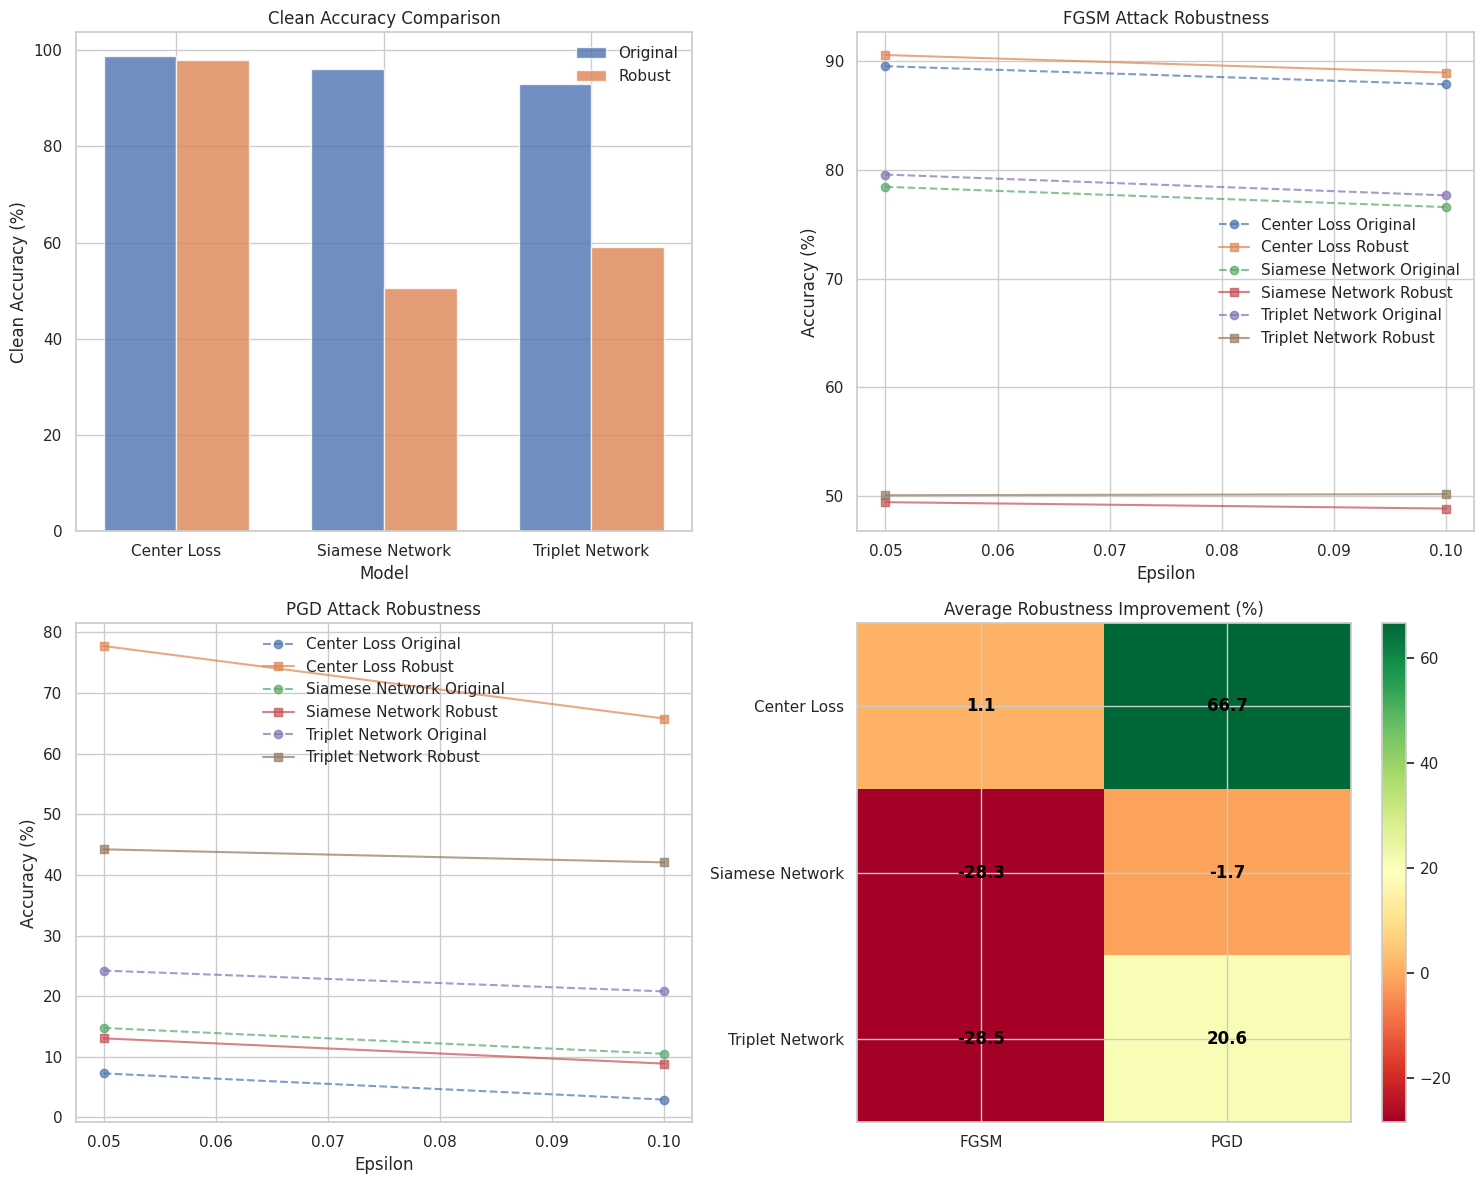

In [50]:
# Visualization functions
def plot_robustness_comparison(original_results, robust_results, model_names):
    """Plot robustness comparison between original and robust models."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot clean accuracy comparison
    models = list(original_results.keys())
    orig_clean = [original_results[model]['clean'] for model in models]
    robust_clean = [robust_results[model]['clean'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    axes[0, 0].bar(x - width/2, orig_clean, width, label='Original', alpha=0.8)
    axes[0, 0].bar(x + width/2, robust_clean, width, label='Robust', alpha=0.8)
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].set_ylabel('Clean Accuracy (%)')
    axes[0, 0].set_title('Clean Accuracy Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([model_names[m] for m in models])
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot FGSM robustness curves
    epsilons = CONFIG['epsilon_values'][1:]

    for i, model in enumerate(models):
        if 'FGSM' in original_results[model]:
            orig_fgsm = [original_results[model]['FGSM'].get(eps, 0) for eps in epsilons]
            robust_fgsm = [robust_results[model]['FGSM'].get(eps, 0) for eps in epsilons]

            axes[0, 1].plot(epsilons, orig_fgsm, 'o--', label=f'{model_names[model]} Original', alpha=0.7)
            axes[0, 1].plot(epsilons, robust_fgsm, 's-', label=f'{model_names[model]} Robust', alpha=0.7)

    axes[0, 1].set_xlabel('Epsilon')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('FGSM Attack Robustness')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot PGD robustness curves
    for i, model in enumerate(models):
        if 'PGD' in original_results[model]:
            orig_pgd = [original_results[model]['PGD'].get(eps, 0) for eps in epsilons]
            robust_pgd = [robust_results[model]['PGD'].get(eps, 0) for eps in epsilons]

            axes[1, 0].plot(epsilons, orig_pgd, 'o--', label=f'{model_names[model]} Original', alpha=0.7)
            axes[1, 0].plot(epsilons, robust_pgd, 's-', label=f'{model_names[model]} Robust', alpha=0.7)

    axes[1, 0].set_xlabel('Epsilon')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('PGD Attack Robustness')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Robustness improvement heatmap
    improvement_data = []
    attack_types = ['FGSM', 'PGD']

    for model in models:
        model_improvements = []
        for attack in attack_types:
            if attack in original_results[model] and attack in robust_results[model]:
                # Average improvement across all epsilon values
                orig_scores = [original_results[model][attack].get(eps, 0) for eps in epsilons]
                robust_scores = [robust_results[model][attack].get(eps, 0) for eps in epsilons]
                avg_improvement = np.mean(np.array(robust_scores) - np.array(orig_scores))
                model_improvements.append(avg_improvement)
            else:
                model_improvements.append(0)
        improvement_data.append(model_improvements)

    im = axes[1, 1].imshow(improvement_data, cmap='RdYlGn', aspect='auto')
    axes[1, 1].set_xticks(range(len(attack_types)))
    axes[1, 1].set_xticklabels(attack_types)
    axes[1, 1].set_yticks(range(len(models)))
    axes[1, 1].set_yticklabels([model_names[m] for m in models])
    axes[1, 1].set_title('Average Robustness Improvement (%)')

    # Add text annotations
    for i in range(len(models)):
        for j in range(len(attack_types)):
            text = axes[1, 1].text(j, i, f'{improvement_data[i][j]:.1f}',
                                 ha="center", va="center", color="black", fontweight="bold")

    plt.colorbar(im, ax=axes[1, 1])
    plt.tight_layout()
    plt.show()

# Create comparison plot
model_names = {
    'center_loss': 'Center Loss',
    'siamese': 'Siamese Network',
    'triplet': 'Triplet Network'
}

plot_robustness_comparison(original_results, robust_results, model_names)

In [51]:
# Visualize adversarial examples
def visualize_adversarial_examples(model, dataloader, model_type, attack_type='FGSM', epsilon=0.03, num_samples=4):
    """Visualize adversarial examples and their effects on similarity assessment."""
    model.eval()

    # Get a batch of examples
    batch = next(iter(dataloader))
    (img1, img2), pair_labels = batch
    img1, img2 = img1[:num_samples].to(CONFIG['device']), img2[:num_samples].to(CONFIG['device'])
    pair_labels = pair_labels[:num_samples].to(CONFIG['device']).flatten()

    # Generate adversarial examples based on model type
    if model_type == 'center_loss':
        wrapper = CenterLossSimilarityWrapper(model, img2)
        attack = AdversarialAttacks.create_attack(attack_type, wrapper, epsilon)
        adv_img1 = attack(img1, pair_labels.long())

        # Get predictions
        with torch.no_grad():
            orig_sim = model.compute_similarity(img1, img2)
            orig_preds = (orig_sim >= 0.5).float()

            adv_sim = model.compute_similarity(adv_img1, img2)
            adv_preds = (adv_sim >= 0.5).float()

    elif model_type == 'siamese':
        wrapper = SiameseWrapper(model, img2)
        attack = AdversarialAttacks.create_attack(attack_type, wrapper, epsilon)
        adv_img1 = attack(img1, pair_labels.long())

        # Get predictions
        with torch.no_grad():
            orig_sim = model(img1, img2).flatten()
            orig_preds = (orig_sim >= 0.5).float()

            adv_sim = model(adv_img1, img2).flatten()
            adv_preds = (adv_sim >= 0.5).float()

    elif model_type == 'triplet':
        wrapper = TripletSimilarityWrapper(model, img2)
        attack = AdversarialAttacks.create_attack(attack_type, wrapper, epsilon)
        adv_img1 = attack(img1, pair_labels.long())

        # Get predictions
        with torch.no_grad():
            orig_sim = model.compute_similarity(img1, img2)
            orig_preds = (orig_sim >= 0.5).float()

            adv_sim = model.compute_similarity(adv_img1, img2)
            adv_preds = (adv_sim >= 0.5).float()

    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Denormalization for visualization
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
    ])

    # Create visualization
    fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))

    for i in range(num_samples):
        # Original first images
        orig_img1 = inv_normalize(img1[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        axes[0, i].imshow(orig_img1)
        axes[0, i].set_title(f'Original Img1\nTrue: {pair_labels[i].item():.0f}, Pred: {orig_preds[i].item():.0f}')
        axes[0, i].axis('off')

        # Target second images
        target_img2 = inv_normalize(img2[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        axes[1, i].imshow(target_img2)
        axes[1, i].set_title(f'Target Img2\n(Similarity target)')
        axes[1, i].axis('off')

        # Adversarial first images
        adv_img1_vis = inv_normalize(adv_img1[i]).permute(1, 2, 0).cpu().numpy().clip(0, 1)
        axes[2, i].imshow(adv_img1_vis)
        axes[2, i].set_title(f'Adversarial Img1 (ε={epsilon})\nTrue: {pair_labels[i].item():.0f}, Pred: {adv_preds[i].item():.0f}')
        axes[2, i].axis('off')

    plt.suptitle(f'{model_type.title()} Model - {attack_type} Attack Examples\nSimilarity Assessment Task')
    plt.tight_layout()
    plt.show()

    # Print similarity scores
    print(f"\nSimilarity Scores:")
    for i in range(num_samples):
        if model_type == 'center_loss':
            orig_score = model.compute_similarity(img1[i:i+1], img2[i:i+1]).item()
            adv_score = model.compute_similarity(adv_img1[i:i+1], img2[i:i+1]).item()
        elif model_type == 'siamese':
            orig_score = model(img1[i:i+1], img2[i:i+1]).item()
            adv_score = model(adv_img1[i:i+1], img2[i:i+1]).item()
        elif model_type == 'triplet':
            orig_score = model.compute_similarity(img1[i:i+1], img2[i:i+1]).item()
            adv_score = model.compute_similarity(adv_img1[i:i+1], img2[i:i+1]).item()

        print(f"Sample {i+1}: Original={orig_score:.3f}, Adversarial={adv_score:.3f}, "
              f"True Label={pair_labels[i].item():.0f}")

print("Adversarial visualization functions defined!")

Adversarial visualization functions defined!


## Section 12: Save Robust Models

Let's save the final robust model checkpoints with comprehensive metadata.

In [53]:
# Save final robust models with comprehensive metadata
import datetime

def save_final_robust_model(model, model_type, original_results, robust_results, training_history):
    """Save robust model with comprehensive evaluation results."""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    checkpoint = {
        'timestamp': timestamp,
        'model_state_dict': model.state_dict(),
        'model_type': model_type,
        'config': CONFIG,

        # Architecture info
        'backbone_name': 'tiny_vit_5m_224.in1k',
        'embedding_dim': CONFIG['embedding_dim'],
        'training_mode': 'fine_tuning',

        # Training info
        'adversarial_training': {
            'method': 'PGD-AT',
            'epsilon': 0.03,
            'epochs': CONFIG['adv_epochs'],
            'training_history': training_history
        },

        # Evaluation results
        'original_performance': original_results,
        'robust_performance': robust_results,

        # Summary metrics
        'summary': {
            'clean_accuracy': robust_results['clean'],
            'fgsm_robustness_avg': np.mean([robust_results['FGSM'][eps] for eps in CONFIG['epsilon_values'][1:]
                                           if eps in robust_results['FGSM']]),
            'pgd_robustness_avg': np.mean([robust_results['PGD'][eps] for eps in CONFIG['epsilon_values'][1:]
                                          if eps in robust_results['PGD']]),
        }
    }

    # Calculate robustness improvements
    if 'FGSM' in original_results and 'FGSM' in robust_results:
        fgsm_improvements = []
        for eps in CONFIG['epsilon_values'][1:]:
            if eps in original_results['FGSM'] and eps in robust_results['FGSM']:
                improvement = robust_results['FGSM'][eps] - original_results['FGSM'][eps]
                fgsm_improvements.append(improvement)
        checkpoint['summary']['fgsm_improvement_avg'] = np.mean(fgsm_improvements) if fgsm_improvements else 0

    if 'PGD' in original_results and 'PGD' in robust_results:
        pgd_improvements = []
        for eps in CONFIG['epsilon_values'][1:]:
            if eps in original_results['PGD'] and eps in robust_results['PGD']:
                improvement = robust_results['PGD'][eps] - original_results['PGD'][eps]
                pgd_improvements.append(improvement)
        checkpoint['summary']['pgd_improvement_avg'] = np.mean(pgd_improvements) if pgd_improvements else 0

    # Save checkpoint
    filename = f'final_robust_{model_type}_model_{timestamp}.pth'
    filepath = os.path.join(CONFIG['robust_model_dir'], filename)
    torch.save(checkpoint, filepath)

    print(f"Saved robust {model_type} model to {filepath}")
    print(f"Summary - Clean Acc: {checkpoint['summary']['clean_accuracy']:.2f}%, "
          f"FGSM Robustness: {checkpoint['summary'].get('fgsm_robustness_avg', 0):.2f}%, "
          f"PGD Robustness: {checkpoint['summary'].get('pgd_robustness_avg', 0):.2f}%")

    return filepath

# Save all robust models
print("Saving final robust model checkpoints...")

center_path = save_final_robust_model(
    robust_center_model, 'center_loss',
    original_results['center_loss'], robust_results['center_loss'],
    {'losses': center_losses, 'val_stats': center_val_stats}
)

siamese_path = save_final_robust_model(
    robust_siamese_model, 'siamese',
    original_results['siamese'], robust_results['siamese'],
    {'losses': siamese_losses, 'val_accuracies': siamese_val_accs}
)

triplet_path = save_final_robust_model(
    robust_triplet_model, 'triplet',
    original_results['triplet'], robust_results['triplet'],
    {'losses': triplet_losses, 'val_accuracies': triplet_val_accs}
)

# Save consolidated results summary
results_summary = {
    'experiment_info': {
        'timestamp': datetime.datetime.now().isoformat(),
        'config': CONFIG,
        'attack_types': ['FGSM', 'PGD'],
        'epsilon_values': CONFIG['epsilon_values']
    },
    'model_paths': {
        'center_loss': center_path,
        'siamese': siamese_path,
        'triplet': triplet_path
    },
    'original_results': original_results,
    'robust_results': robust_results,
    'comparison': {}
}

# Add comparison metrics
for model_type in ['center_loss', 'siamese', 'triplet']:
    results_summary['comparison'][model_type] = {
        'clean_accuracy_drop': robust_results[model_type]['clean'] - original_results[model_type]['clean'],
        'robustness_gain': {}
    }

    for attack in ['FGSM', 'PGD']:
        if attack in original_results[model_type] and attack in robust_results[model_type]:
            improvements = []
            for eps in CONFIG['epsilon_values'][1:]:
                if eps in original_results[model_type][attack] and eps in robust_results[model_type][attack]:
                    improvement = robust_results[model_type][attack][eps] - original_results[model_type][attack][eps]
                    improvements.append(improvement)
            results_summary['comparison'][model_type]['robustness_gain'][attack] = np.mean(improvements) if improvements else 0

# Save results summary
summary_path = os.path.join(CONFIG['output_dir'], 'adversarial_robustness_summary.json')
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nSaved experiment summary to {summary_path}")
print("All robust models and results saved successfully!")

Saving final robust model checkpoints...
Saved robust center_loss model to robust_models/final_robust_center_loss_model_20250723_005541.pth
Summary - Clean Acc: 98.04%, FGSM Robustness: 89.73%, PGD Robustness: 71.76%
Saved robust siamese model to robust_models/final_robust_siamese_model_20250723_005541.pth
Summary - Clean Acc: 50.54%, FGSM Robustness: 49.17%, PGD Robustness: 10.96%


NameError: name 'triplet_losses' is not defined